Esta notebook contiene bloques de código útiles para el juego TacTix

In [2]:
from tactix_env import TacTixEnv
from trainer_agent import TrainerAgent
from random_agent import RandomTacTixAgent
from play import play_vs_other_agent, run_multiple_games, plot_results

In [3]:
env = TacTixEnv(board_size=6, misere=False)
obs = env.reset()
env.render()

# Example action: take from row 1, positions 0 to 2
obs, reward, done, _ = env.step([1, 0, 2, 1])
env.render()

O O O O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
Player 1's turn (Normal rules)

O O O O O O
. . . O O O
O O O O O O
O O O O O O
O O O O O O
O O O O O O
Player 2's turn (Normal rules)



In [4]:
env.action_space.sample()

array([2, 4, 1, 0])

In [5]:
env.observation_space.sample()

{'board': array([[1, 0, 1, 0, 1, 0],
        [1, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 1],
        [0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1],
        [1, 0, 1, 1, 0, 0]], dtype=int32),
 'current_player': np.int64(0)}

Random Agents

In [6]:
random_agent_1 = RandomTacTixAgent(env)
random_agent_2 = RandomTacTixAgent(env)

play_vs_other_agent(env, random_agent_1, random_agent_2, render=False)

Agent 2 wins!


2

Multiple Games

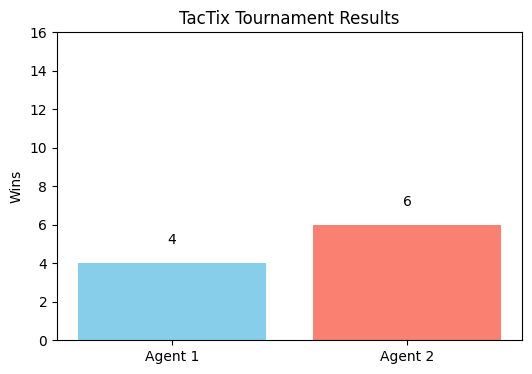

In [7]:
results = run_multiple_games(env, random_agent_1, random_agent_2, num_games=10)
plot_results(results)

## Play vs trainer

In [9]:
# Run a series of games with different difficulties for the TrainerAgent
difficulties = [i / 10 for i in range(11)]
results_summary = []

for d in difficulties:
    agent1 = TrainerAgent(env, difficulty=d)
    agent2 = RandomTacTixAgent(env)
    
    results = run_multiple_games(env, agent1, agent2, num_games=200)
    results_summary.append((d, results["agent1_wins"], results["agent2_wins"]))
    

In [ ]:
# Mostrar resultados
print("Probability | Agent 1 Wins | Agent 2 Wins")
for d, agent1_wins, agent2_wins in results_summary:
    print(f"{d:.1f}         | {agent1_wins}          | {agent2_wins}")

Probability | Agent 1 Wins | Agent 2 Wins
0.0         | 90          | 110
0.1         | 115          | 85
0.2         | 121          | 79
0.3         | 114          | 86
0.4         | 153          | 47
0.5         | 139          | 61
0.6         | 151          | 49
0.7         | 156          | 44
0.8         | 161          | 39
0.9         | 157          | 43
1.0         | 165          | 35


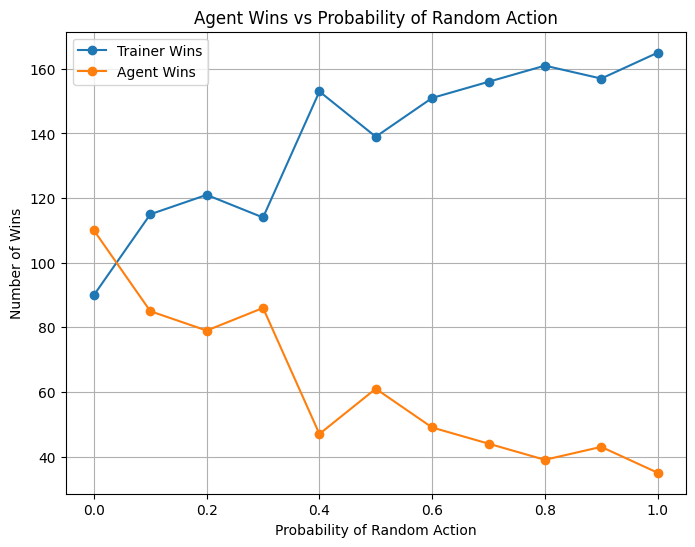

In [ ]:
# Plot results
import matplotlib.pyplot as plt

probs = [x[0] for x in results_summary]
agent1_wins = [x[1] for x in results_summary]
agent2_wins = [x[2] for x in results_summary]

plt.figure(figsize=(8, 6))
plt.plot(probs, agent1_wins, label="Trainer Wins", marker='o')
plt.plot(probs, agent2_wins, label="Agent Wins", marker='o')
plt.xlabel("Difficulty")
plt.ylabel("Number of Wins")
plt.title("Agent Wins vs Difficulty")
plt.legend()
plt.grid()
plt.show()